In [1]:
import matplotlib.pyplot as plt
import scipy.integrate
import torch
import sys  
sys.path.insert(0, '..')

from hnn.simulation import get_dataset, get_field, get_trajectory, get_vector_field, integrate_model
from hnn.train import train

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn') # solenoidal, conservative
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

In [3]:
args = get_args()
model, stats = train(args)

OK FFJJFJF solenoidal
X shape torch.Size([50, 90, 2]) DX shape torch.Size([50, 90, 2])
step 0, train_loss 6.2286e+00, test_loss 5.6657e+00
step 1, train_loss 5.9961e+00, test_loss 5.4393e+00
step 2, train_loss 5.7690e+00, test_loss 5.2167e+00
step 3, train_loss 5.5457e+00, test_loss 4.9965e+00
step 4, train_loss 5.3248e+00, test_loss 4.7778e+00
step 5, train_loss 5.1054e+00, test_loss 4.5599e+00
step 6, train_loss 4.8868e+00, test_loss 4.3426e+00
step 7, train_loss 4.6687e+00, test_loss 4.1258e+00
step 8, train_loss 4.4510e+00, test_loss 3.9100e+00
step 9, train_loss 4.2340e+00, test_loss 3.6955e+00
step 10, train_loss 4.0180e+00, test_loss 3.4828e+00
step 11, train_loss 3.8036e+00, test_loss 3.2726e+00
step 12, train_loss 3.5913e+00, test_loss 3.0657e+00
step 13, train_loss 3.3819e+00, test_loss 2.8632e+00
step 14, train_loss 3.1763e+00, test_loss 2.6660e+00
step 15, train_loss 2.9755e+00, test_loss 2.4753e+00
step 16, train_loss 2.7806e+00, test_loss 2.2924e+00
step 17, train_loss 2.

In [4]:
R = 2.5
t_span=[0.0, 28.0]
Y0 = torch.tensor([2.1, 0.0])
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

field_args = {
    'xmin': -R,
    'xmax': R,
    'ymin': -R,
    'ymax': R,
    'gridsize': 10,
}

In [5]:

ivp = integrate_model(
        model,
        t_span,
        y0=Y0,
        timescale=100,
        rtol=1e-12
)

field = get_field(**field_args)
vector_field = get_vector_field(model, **field_args)


/opt/homebrew/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


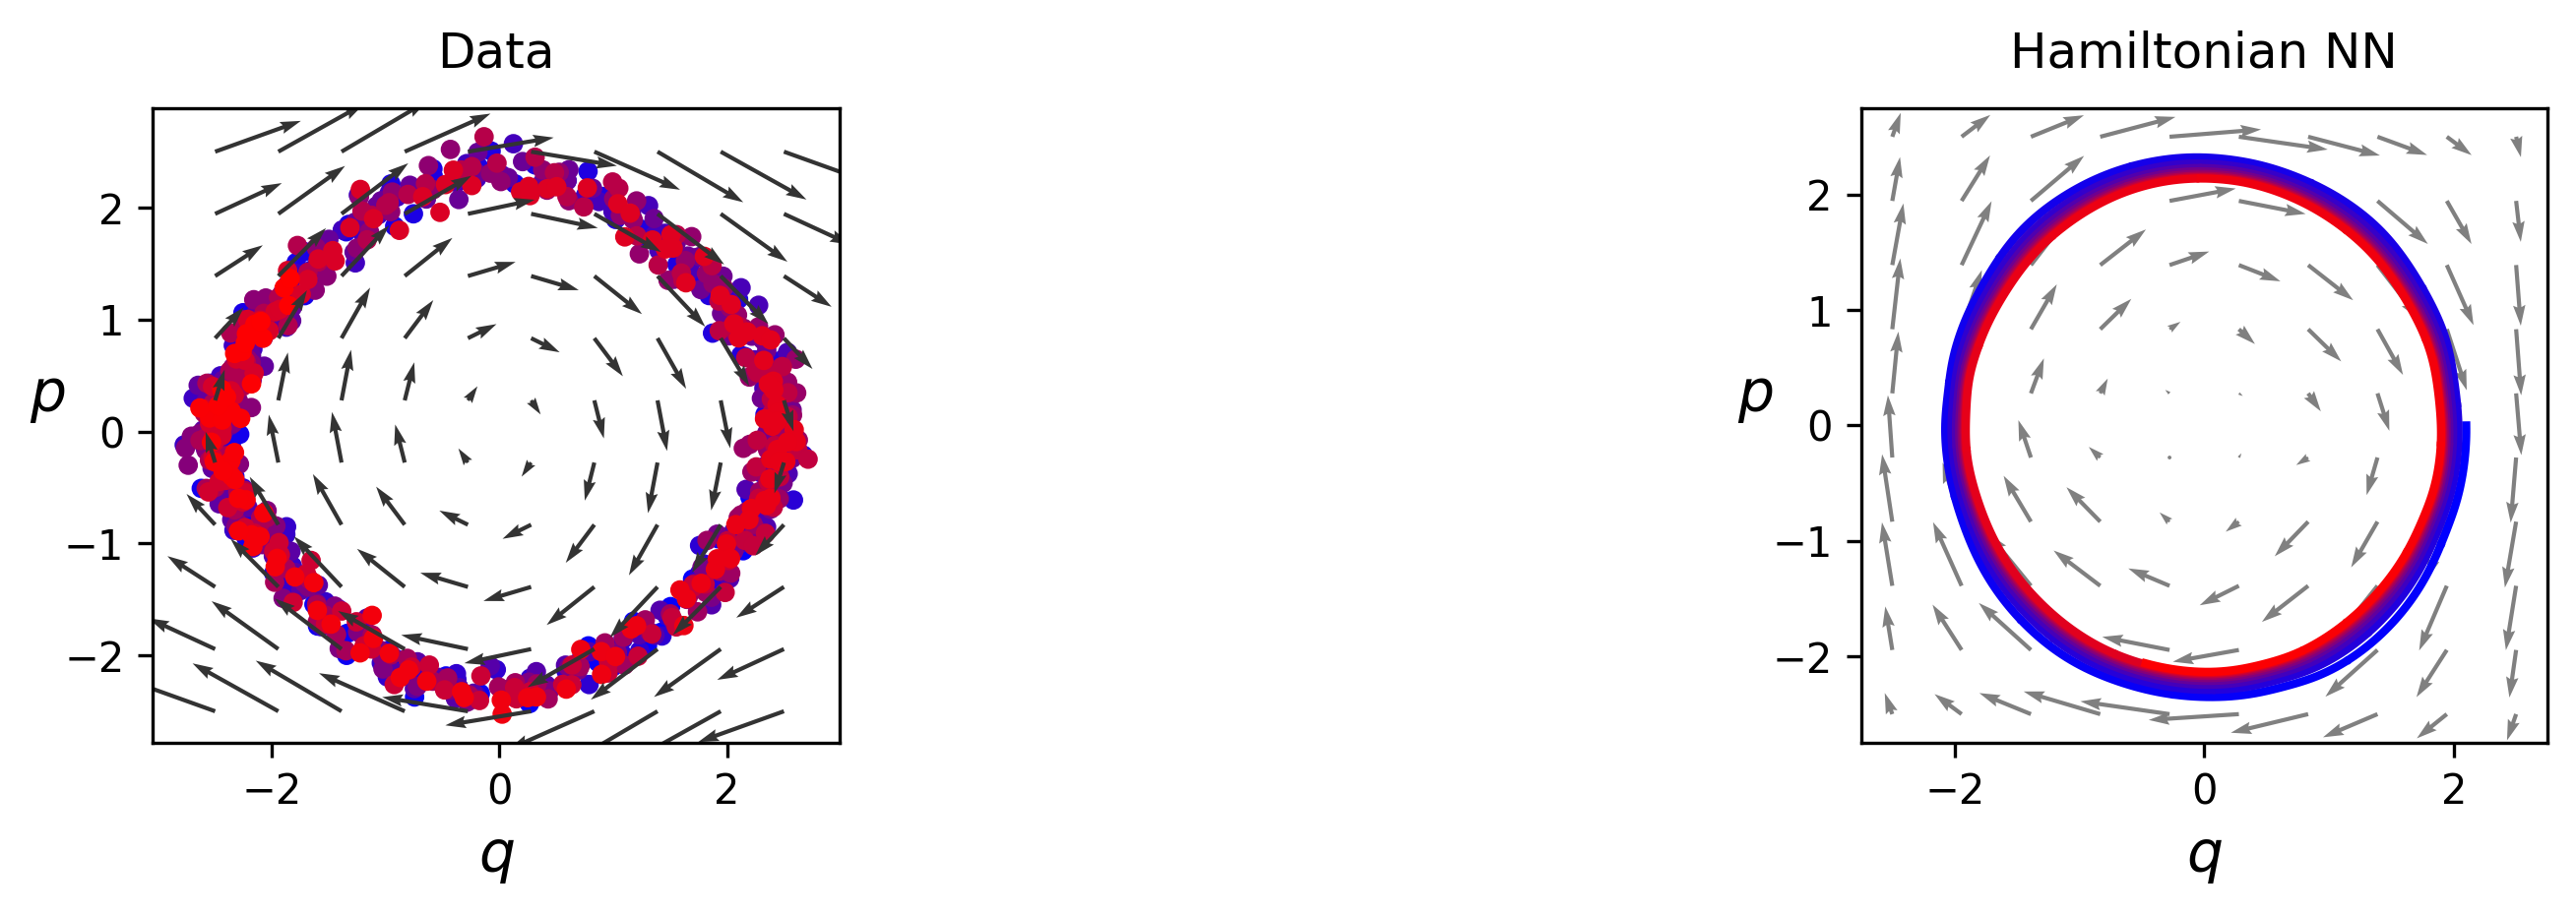

In [6]:
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=300)

# plot data
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=t_span, radius=R, y0=Y0)
N = x.shape[1]
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x, y, s=14, label='data', c=point_colors)
plt.quiver(
        field['x'][:,:,0],
        field['x'][:,:,1],
        field['dx'][:,0],
        field['dx'][:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.2,.2,.2)
)  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot HNN-modeled data
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(
        field['x'][:,:,0],
        field['x'][:,:,1],
        vector_field[:,:,0],
        vector_field[:,:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.5,.5,.5)
)


lines = round(ivp.shape[0] / 30)

for i, l in enumerate(torch.tensor_split(ivp, lines)):
        color = (float(i)/lines, 0, 1-float(i)/lines)
        plt.plot(l[:, 0], l[:, 1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.tight_layout() ; plt.show()